# Error analysis on San Jose Census Block Groups

In [9]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds

In [15]:
import json
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
from pyproj import Geod
import rasterio
import rasterio.plot
from rasterio.transform import from_bounds
import rasterio.features
import seaborn as sns
import shapely
from shapely.geometry import box, Polygon
from shapely.ops import orient
from tqdm import tqdm

tqdm.pandas()

In [16]:
# Paths
TIF_FP = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020')
INFERENCES_DIR = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
IMG_FP = os.path.join(OAK_FP, 'san_jose_naip_512', 'phase2_superresx2')

In [17]:
# Params
N_CBGS = 20
N_CBG_TILES = 2
CBG_SAMPLING_TYPE = 'random'
N_EXTREME_TILES = 50

Functions (to be imported from other notebooks)

In [19]:
cbg_sj, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
building_footprints_infer = gpd.read_file(os.path.join(OUTPUT_FP, 'inference_building_processed'))
building_footprints_osm = gpd.read_file(os.path.join(OUTPUT_FP,'osm_building_processed'))
cbg_footprints = gpd.read_file(os.path.join(OUTPUT_FP, 'cbg_aggregate'))

## Functions

In [20]:
def get_error_masks(infer_tile, osm_tile):
    e_gdf = gpd.GeoDataFrame(geometry=[], crs='EPSG:4326')
    
    if len(infer_tile) == 0 and len(osm_tile) == 0:
        return e_gdf.copy(), e_gdf.copy(), e_gdf.copy(), e_gdf.copy()
    
    if len(infer_tile) == 0:
        false_pos = e_gdf.copy()
        false_neg = osm_tile.copy()
        FP_detached = e_gdf.copy()
        FP_attached = e_gdf.copy()
        return false_pos, false_neg, FP_detached, FP_attached
        
    # Explode multipolygons and remove Points
    infer_tile = infer_tile.explode(index_parts=True).reset_index(drop=True)
    infer_tile = infer_tile.loc[infer_tile.geometry.apply(lambda x: isinstance(x, shapely.geometry.polygon.Polygon))]
    
    if len(osm_tile) == 0:
        false_pos = infer_tile.copy()
        false_neg = e_gdf.copy()
        FP_detached = infer_tile.copy()
        FP_attached = e_gdf.copy()
        return false_pos, false_neg, FP_detached, FP_attached
        
    # "False positive" buildings (could be actual false positive or potentially small buildings not detected by OSM)
    false_pos = gpd.overlay(infer_tile[['geometry']], osm_tile[['geometry']], how='difference')

    # False negatives -- which are we missing
    false_neg = gpd.overlay(osm_tile[['geometry']], infer_tile[['geometry']], how='difference')

    # FP Detached buildings
    FP_detached = infer_tile.sjoin(osm_tile[['geometry']], how='left', predicate='intersects')
    FP_detached = FP_detached.loc[FP_detached.index_right.isna()]
    
    # Attachments
    if len(false_pos) == 0:
        FP_attached = e_gdf.copy()
    elif len(FP_detached) == 0:
        FP_attached = false_pos.copy()
    else:
        FP_attached = gpd.overlay(false_pos, FP_detached, how='difference')

    return false_pos, false_neg, FP_detached, FP_attached

In [21]:
def compute_tile_error(infer_tile, osm_tile):
    # Compute errors
    false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)
    
    # Handle masks with no polygons
    # Note: we add a negligible buffer to handle self-intersecting polygons
    B = 0.0000001
    false_pos_area = false_pos.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if false_pos.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    false_neg_area = false_neg.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if false_neg.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    FP_detached_area = FP_detached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if FP_detached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    FP_attached_area = FP_attached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if FP_attached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    
    # Save tile errors
    tile_error = {
        'false_pos_area': false_pos_area,
        'false_neg_area': false_neg_area,
        'FP_detached_area': FP_detached_area,
        'FP_attached_area': FP_attached_area
    }

    # Normalize by total built area (per OSM)
    if len(osm_tile) == 0:
        for key in list(tile_error.keys()):
            tile_error[key.replace('area', 'perc')] = None
    else:
        tile_built_area = osm_tile.to_crs('EPSG:26910').geometry.unary_union.area
        for key in list(tile_error.keys()):
            tile_error[key.replace('area', 'perc')] = tile_error[key] / tile_built_area * 100
    
    return tile_error

In [23]:
# Visualize (sampled) tiles
def visualize_tile(tile_bounds_dict, file_name, save=False):
    # Get image, OSM and inference
    img_file = None
    for dirname in ['train', 'val', 'test']:
        dirpath = os.path.join(IMG_FP, dirname, 'images', '{}.npy'.format(file_name))
        if os.path.exists(dirpath):
            img_file = dirpath
            
    tile_img = np.load(img_file)
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    
    # Get raster for plotting purposes
    raster = rasterio.open(os.path.join(TIF_FP, '{}.tif'.format(file_name)))
    t = from_bounds(*raster.bounds, tile_img.shape[0], tile_img.shape[1])
    
    # Get error masks
    #false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)
    
    # Get shape boundaries
    infer_tile_ext = infer_tile.copy()
    infer_tile_ext.geometry = infer_tile_ext.geometry.exterior

    osm_tile_ext = osm_tile.copy()
    osm_tile_ext.geometry = osm_tile_ext.geometry.exterior
    
    # Get small OSM & Inference buildings
    #geod = Geod(ellps="WGS84")
    #infer_tile_small = infer_tile.copy()
    #infer_tile_small['area'] = infer_tile_small['geometry'].apply(
    #    lambda x: geod.geometry_area_perimeter(orient(x))[0])
    #infer_tile_small = infer_tile_small.loc[infer_tile_small['area'] < 120]
    
    #osm_tile_small = osm_tile.copy()
    #osm_tile_small['area'] = osm_tile_small['geometry'].apply(
    #    lambda x: geod.geometry_area_perimeter(orient(x))[0])
    #osm_tile_small = osm_tile_small.loc[osm_tile_small['area'] < 120]
    
    infer_tile_small = infer_tile.loc[infer_tile.small == 1]
    osm_tile_small = osm_tile.loc[osm_tile.small == 1]
    
    infer_tile_small_ext = infer_tile_small.copy()
    infer_tile_small_ext.geometry = infer_tile_small_ext.geometry.exterior

    osm_tile_small_ext = osm_tile_small.copy()
    osm_tile_small_ext.geometry = osm_tile_small_ext.geometry.exterior
    
    # Plot inference vs OSM
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 15))
    rasterio.plot.show(np.moveaxis(tile_img, 2, 0),transform=t, ax=ax)
    if len(infer_tile_ext) > 0:
        infer_tile_ext.to_crs('EPSG:26910').plot(ax=ax, alpha=1, color='red')
    if len(osm_tile_ext) > 0:
        osm_tile_ext.to_crs('EPSG:26910').plot(ax=ax, alpha=1, color='blue')
    ax.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_FP, 'Error-Analysis', 'Visualizations', '{}-comp.png'.format(file_name)), bbox_inches='tight')
    else:
        plt.show()
    
    # Plot small buildings
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 15))
    rasterio.plot.show(np.moveaxis(tile_img, 2, 0),transform=t, ax=ax)
    if len(infer_tile_small_ext) > 0:
        infer_tile_small_ext.to_crs('EPSG:26910').plot(ax=ax, alpha=1, color='red')
    if len(osm_tile_small_ext) > 0:
        osm_tile_small_ext.to_crs('EPSG:26910').plot(ax=ax, alpha=1, color='blue')
    ax.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_FP, 'Error-Analysis', 'Visualizations', '{}-small.png'.format(file_name)), bbox_inches='tight')
    else:
        plt.show()

In [24]:
def visualize_tile_only(file):
    raster = rasterio.open(os.path.join(TIF_FP, '{}.tif'.format(file)))
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    rasterio.plot.show(raster, ax=ax)
    plt.show()

In [25]:
def visualize_tile_full(fn):
    tile_bounds = get_bounds(tile_bounds_dict, fn)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    zone_tile = gpd.clip(zoning, tile_bounds)

    raster = rasterio.open(os.path.join(TIF_FP, '{}.tif'.format(fn)))

    plt.clf()
    fig, ax = plt.subplots(figsize=(4, 4))
    rasterio.plot.show(raster, ax=ax, transform=t)
    zone_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='black', alpha=0.5)
    osm_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue')
    infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='red', alpha=0.5)
    plt.show()

## Compute errors for all tiles

In [26]:
with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
    tile_bounds_dict = json.load(f)

In [28]:
# Get tiles
tiles = glob.glob(os.path.join(INFERENCES_DIR, '*.npy'))
tiles = [t.split(os.path.sep)[-1].replace('.npy', '') for t in tiles]

# Compute errors for all tiles
tile_metrics_fp = os.path.join(OUTPUT_FP, 'Error-Analysis', 'tile-metrics-df.csv')
if os.path.exists(tile_metrics_fp):
    tile_metrics_pd = pd.read_csv(tile_metrics_fp)
    computed_tiles = tile_metrics_pd['file'].unique()
    tiles = set(tiles).difference(set(computed_tiles))
    tiles = list(tiles)
else:
    tile_metrics_pd = pd.DataFrame()

print('[INFO] Computing tile errors for {} tiles'.format(len(tiles)))
for i, file_name in tqdm(enumerate(tiles)):
    # Compute tile errors
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    tile_error = compute_tile_error(infer_tile, osm_tile)
    
    # Append to DataFrame
    tile_error = pd.DataFrame.from_dict({k: [v] for k, v in tile_error.items()})
    tile_error['file'] = [file_name]
    tile_metrics_pd = pd.concat([tile_metrics_pd, tile_error])
    
    # Save progress
    if i % 50 == 0 or i == len(tiles) - 1:
        tile_metrics_pd.to_csv(tile_metrics_fp, index=False)

[INFO] Computing tile errors for 0 tiles


0it [00:00, ?it/s]


## Stratified Random Sampling

In [29]:
# Stratify by CBG
tile_metrics_pd  = pd.read_csv(tile_metrics_fp)

tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
    lambda name: get_bounds(tile_bounds_dict, name)
)

100%|██████████| 3074/3074 [00:00<00:00, 52583.82it/s]


In [30]:
tile_metrics_pd = gpd.GeoDataFrame(tile_metrics_pd, crs='EPSG:4326')
assert tile_metrics_pd.crs == cbg_sj.crs

In [16]:
# SJoin by cbg with most overlap
tile_metrics_cbg = gpd.sjoin(
        cbg_sj[['GEOID', 'geometry']], tile_metrics_pd, 
        how='right', predicate='intersects')

tile_metrics_cbg['intersection'] = tile_metrics_cbg.progress_apply(
    lambda x: x['geometry'].intersection(cbg_sj.loc[cbg_sj['GEOID'] == x['GEOID']].iloc[0]['geometry']).area,
    axis=1)

tile_metrics_cbg = tile_metrics_cbg.sort_values(by='intersection')

tile_metrics_cbg.drop_duplicates(inplace=True, subset='geometry', keep='last')
tile_metrics_cbg.drop('intersection', axis=1, inplace=True)

# Verify we have all the original tiles (once)
assert len(tile_metrics_cbg.file) == len(tile_metrics_pd.file)

# Visualize tile overlap
#fig, ax = plt.subplots(figsize=(15, 15))
#tile_metrics_pd.plot(edgecolor='black', facecolor='white', ax=ax)
#cbg_sj.plot(edgecolor='red', facecolor='none', ax=ax)
#plt.show()

100%|██████████| 7265/7265 [00:16<00:00, 448.18it/s]


In [17]:
# Keep only statistics for small buildings
cbg_footprints = cbg_footprints.loc[cbg_footprints.small == 1]

# Drop CBGs with missing OSM data
cbg_footprints = cbg_footprints.loc[~cbg_footprints.b_n_osm.isna()]

In [18]:
# Get tiles for each CBG
cbg_tiles = tile_metrics_cbg.groupby('GEOID')['file'].unique().to_frame().reset_index()
cbg_footprints = cbg_footprints.merge(cbg_tiles, how='left')

In [19]:
# Select CBGs
if CBG_SAMPLING_TYPE == 'residuals':
    # Identify CBGs with highest residuals (for stratification)
    cbg_footprints['b_n_resi'] = cbg_footprints['b_n_inf'] - cbg_footprints['b_n_osm']
    cbg_footprints.sort_values(by='b_n_resi', inplace=True)

    # Grab bottom and top N_CBGS
    cbg_footprints_sampled = pd.concat([cbg_footprints.head(N_CBGS), cbg_footprints.tail(N_CBGS)])
elif CBG_SAMPLING_TYPE == 'random':
    np.random.seed(42)
    selected_cbgs = np.random.choice(list(range(len(cbg_footprints))), size=N_CBGS * 2, replace=False)
    cbg_footprints_sampled = cbg_footprints.iloc[selected_cbgs].copy()

In [20]:
np.random.seed(42)
# Sample tiles from selected CBGs
cbg_footprints_sampled['sampled_tiles'] = cbg_footprints_sampled['file'].apply(
    lambda tile_list: None if pd.isna([tile_list]).sum() else np.random.choice(
        tile_list, size=N_CBG_TILES if len(tile_list) >= N_CBG_TILES else 1, replace=False))

In [21]:
# Add sampled tiles to main DF
tile_metrics_cbg['sampled'] = tile_metrics_cbg['file'].isin(cbg_footprints_sampled['sampled_tiles'].explode().to_numpy())
print('Sampled tiles: {}'.format(tile_metrics_cbg['sampled'].sum()))

# Add sampling rationale
tile_metrics_cbg['sample_rationale'] = tile_metrics_cbg['sampled'].apply(
    lambda x: 'CBG' if x == 1 else None)

Sampled tiles: 69


In [22]:
# Get tile OSM building area
tile_build_area = tile_metrics_cbg[['file', 'geometry']].sjoin(
    building_footprints_osm[['area', 'geometry']], predicate='intersects', how='right')
tile_build_area = tile_build_area.groupby('file')['area'].sum().reset_index()

tile_metrics_cbg = tile_metrics_cbg.merge(tile_build_area[['file', 'area']], on='file', how='left')

# Assign a zero area value for tiles with missing area (as there are no OSM buildings here)
tile_metrics_cbg['area'] = tile_metrics_cbg['area'].fillna(value=0)
tile_metrics_cbg = tile_metrics_cbg.rename(columns={'area': 'osm_area'})

In [152]:
#tile_metrics_cbg['osm_area'].hist()
#plt.show()

In [23]:
# Sample tiles with extreme FP or FN values
# Note: Use a minimum threshold area.
# Tiles with relevant building area have areas approx. >= 4k
osm_build_threshold = 4000

tile_metrics_cbg_FN = tile_metrics_cbg.loc[tile_metrics_cbg['osm_area'] > osm_build_threshold].sort_values(
    by='false_neg_perc', inplace=False)
tile_metrics_cbg_FN = tile_metrics_cbg_FN.tail(N_EXTREME_TILES // 2)

tile_metrics_cbg_FP = tile_metrics_cbg.loc[tile_metrics_cbg['osm_area'] > osm_build_threshold].sort_values(
    by='false_pos_perc', inplace=False)
tile_metrics_cbg_FP = tile_metrics_cbg_FP.tail(N_EXTREME_TILES // 2)

FP_FN_tiles = set(tile_metrics_cbg_FP['file']).union(set(tile_metrics_cbg_FN['file']))

In [24]:
tile_metrics_cbg['sampled'] = tile_metrics_cbg.apply(
    lambda x: 1 if x['sampled'] == True else x['file'] in(FP_FN_tiles), axis=1)

# Add sampling rationale
tile_metrics_cbg['sample_rationale'] = tile_metrics_cbg.apply(
    lambda x: 'Extremes' if x['file'] in FP_FN_tiles else x['sample_rationale'], axis=1)

print('Sampled tiles: {}'.format(tile_metrics_cbg['sampled'].sum()))

Sampled tiles: 117


In [25]:
sampled_tiles = tile_metrics_cbg.loc[tile_metrics_cbg['sampled'] == True].copy()

In [181]:
# Add building information to each tile
def get_num_buildings(file_name):
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    
    # Get small OSM & Inference buildings
    infer_tile_small = infer_tile.loc[infer_tile.small == 1]
    osm_tile_small = osm_tile.loc[osm_tile.small == 1]
    
    # Get polygon centroids for inferred buildings
    centroids = infer_tile_small['geometry'].apply(lambda geom: list(geom.centroid.coords))
    
    return pd.Series([len(infer_tile_small), len(osm_tile_small), centroids.to_list()])

In [182]:
sampled_tiles[['n_infer', 'n_osm', 'list_infer']] = sampled_tiles.progress_apply(
    lambda x: get_num_buildings(x['file']), axis=1)

100%|██████████| 117/117 [39:33<00:00, 20.29s/it]


In [183]:
sampled_tiles.head(20)

index_left         GEOID  false_pos_area  false_neg_area  \
13        18907  060855119181       51.880567       43.354841   
31        10728  060855005005     1880.207239     3140.443283   
51        18928  060855032212     1759.000693      453.924341   
69        10779  060855119103     2765.836797     1605.184482   
70         3195  060855043201    10376.558583      481.854795   
75         3226  060855044112     7233.789607      686.966187   
76        15299  060855068042     3046.037203     4918.188451   
84         9271  060855068022    14526.955894      267.007751   
108        3234  060855037071     2096.856810     2545.278996   
111       18981  060855120543      193.116757     4403.413960   
131        9271  060855068022    15424.046741      365.026829   
134       18981  060855120543     1706.259738     3967.141801   
163       18907  060855119181     3577.794938     1807.705568   
170       18986  060855120562     1041.857311      740.487094   
189       10845  060855020022      655.731077     1209.226631   
204       16249  060855119113    10415.885116      414.243137   
205        8356  060855065052     1727.712794     3974.398118   
222       14232  060855014012     3462.441430      245.772373   
282        3117  060855032071     3616.341925     3946.010780   
300       10941  060855029093     1545.317062     3663.803333   

     FP_detached_area  FP_attached_area  false_pos_perc  false_neg_perc  \
13           0.726736         51.153831       10.293521        8.601949   
31         109.334322       1770.872918       31.393953       52.436204   
51         980.621739        778.378954       33.018695        8.520741   
69        1915.861508        849.975289       41.632747       24.162033   
70        7274.893308       3101.665275      126.360862        5.867802   
75        5321.647343       1912.142265      195.876786       18.601692   
76          50.175967       2995.861236       40.039148       64.647955   
84        7795.995417       6730.960477      252.118844        4.633984   
108        446.041244       1650.815566       15.350833       18.633677   
111         15.332471        177.784285        1.758043       40.086585   
131       8555.946017       6868.100724      196.329996        4.646363   
134        551.593772       1154.665966       13.535410       31.470526   
163        836.436526       2741.358412       42.389983       21.417832   
170        241.455539        800.401772       16.278848       11.569989   
189        170.817696        484.913381        8.572090       15.807699   
204       9957.432652        458.452464      192.579845        7.658963   
205         68.552287       1659.160507        6.608334       15.201689   
222       2798.820453        663.620978      120.071053        8.522931   
282        473.604369       3142.737556       45.636452       49.796710   
300        235.315725       1310.001338        5.925985       14.049959   

     FP_detached_perc  FP_attached_perc                              file  \
13           0.144190         10.149331  m_3712149_ne_10_060_20200525_358   
31           1.825563         29.568391  m_3712141_nw_10_060_20200525_319   
51          18.407526         14.611170   m_3712142_sw_10_060_20200525_88   
69          28.838498         12.794250  m_3712149_ne_10_060_20200525_319   
70          88.590237         37.770624  m_3712133_se_10_060_20200525_239   
75         144.099736         51.777049  m_3712133_se_10_060_20200525_199   
76           0.659546         39.379602  m_3712149_nw_10_060_20200527_119   
84         135.301392        116.817452   m_3712149_nw_10_060_20200527_19   
108          3.265414         12.085419  m_3712142_nw_10_060_20200525_106   
111          0.139580          1.618464  m_3712142_sw_10_060_20200525_270   
131        108.907142         87.422854    m_3712149_ne_10_060_20200525_1   
134          4.375681          9.159729  m_3712142_sw_10_060_20200525_272   
163          9.910163         32.479821  m_3712149_ne_10_060_2

In [187]:
# Generate visualizations
_ = sampled_tiles['file'].progress_apply(lambda file_name: visualize_tile(tile_bounds_dict, file_name, save=True))

  9%|▊         | 10/117 [03:32<40:41, 22.82s/it]<ipython-input-185-21fcb2542d3a>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 15))
100%|██████████| 117/117 [48:09<00:00, 24.69s/it]


In [188]:
# Save csv file
sampled_tiles[['file', 'GEOID', 'sample_rationale', 'false_pos_area', 'false_neg_area',
       'FP_detached_area', 'FP_attached_area', 'false_pos_perc',
       'false_neg_perc', 'FP_detached_perc', 'FP_attached_perc',
       'n_infer', 'n_osm', 'list_infer']].to_csv(os.path.join(OUTPUT_FP, 'Error-Analysis', 'sampled_tiles.csv'), index=False)

## Visualize CBG-level and tile-level errors

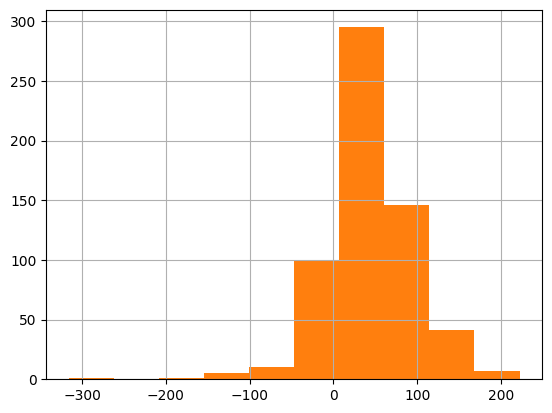

In [61]:
cbg_footprints['b_n_resi'].hist()
plt.show()

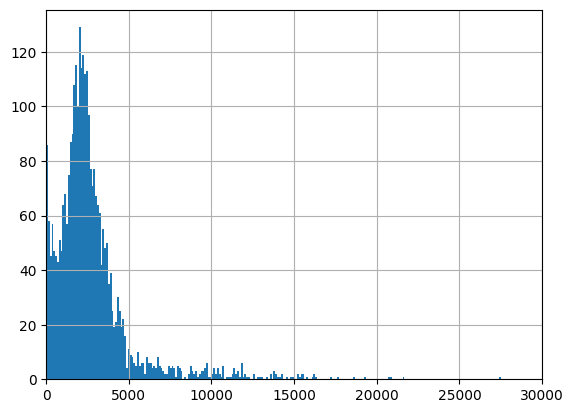

In [189]:
tile_metrics_pd['false_pos_area'].hist(bins=250)
plt.xlim([0, 30000])
plt.show()

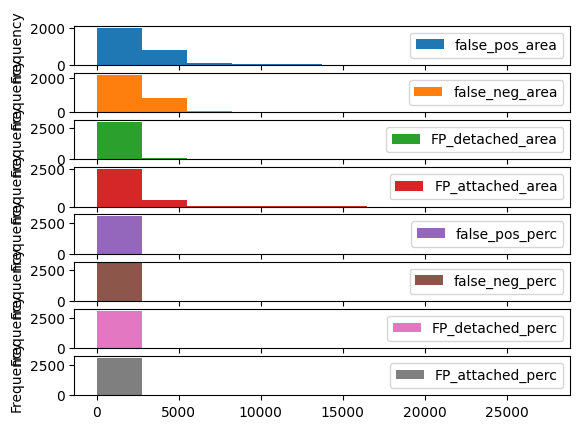

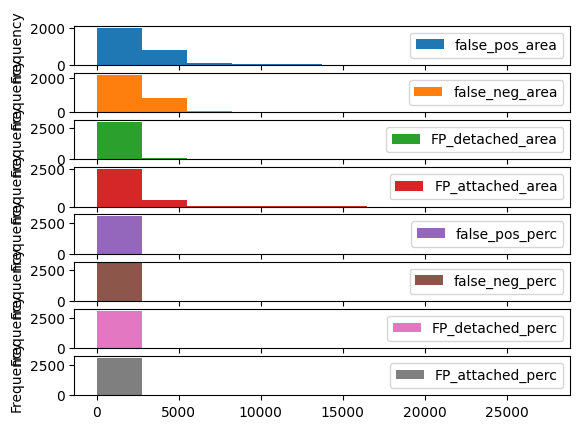

In [179]:
# Sample and visualize tiles with highest errors
tile_metrics_pd.plot.hist(subplots=True)
plt.show()

Geographic distribution of errors

false_pos_area


<Figure size 640x480 with 0 Axes>

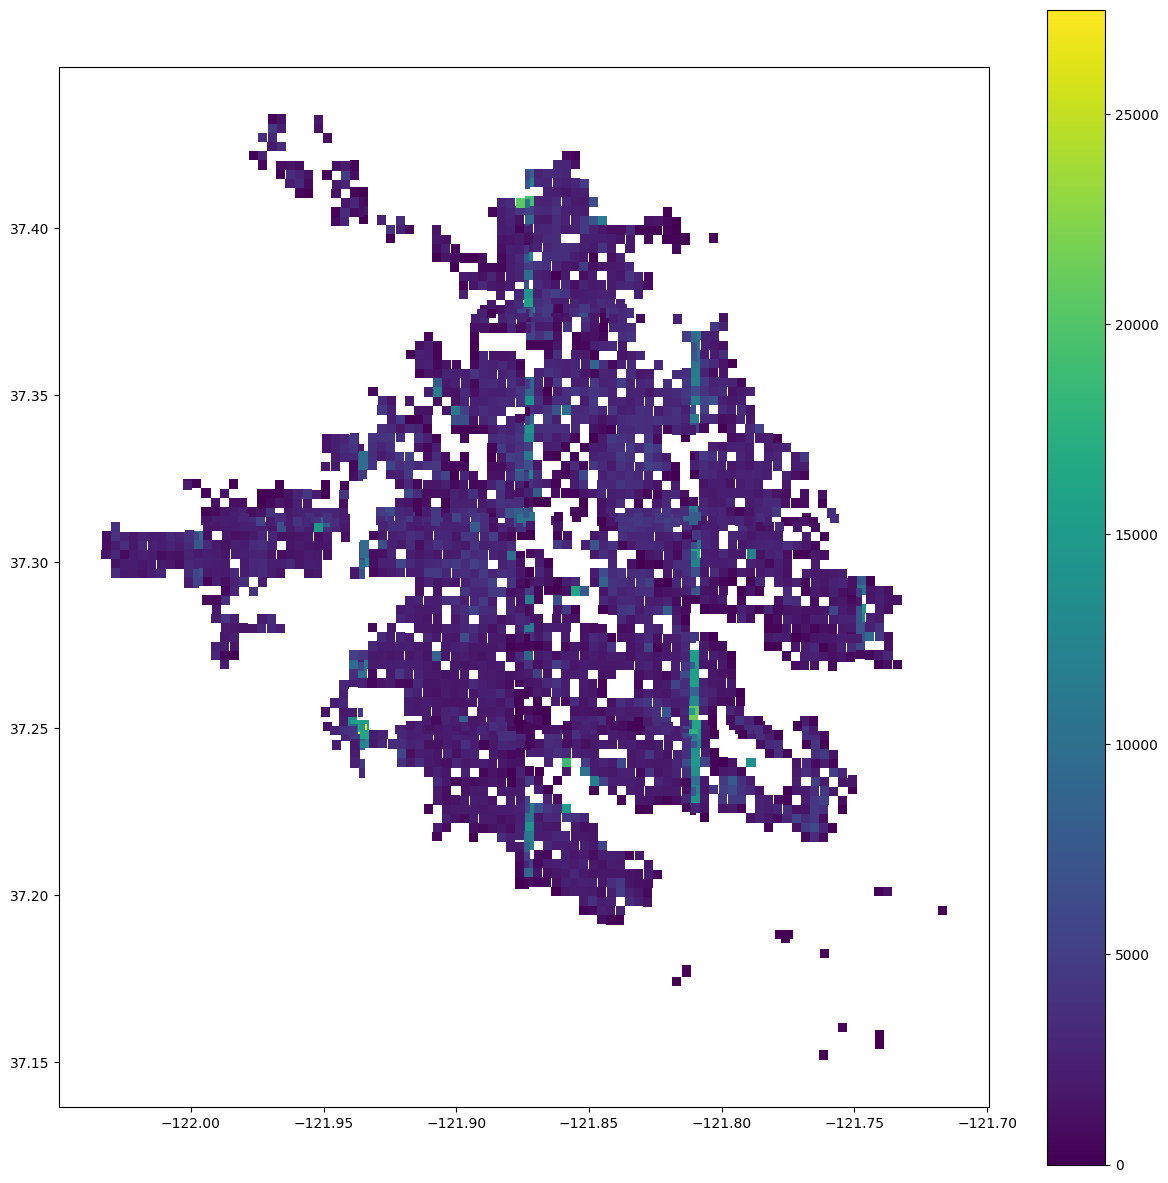

false_neg_area


<Figure size 640x480 with 0 Axes>

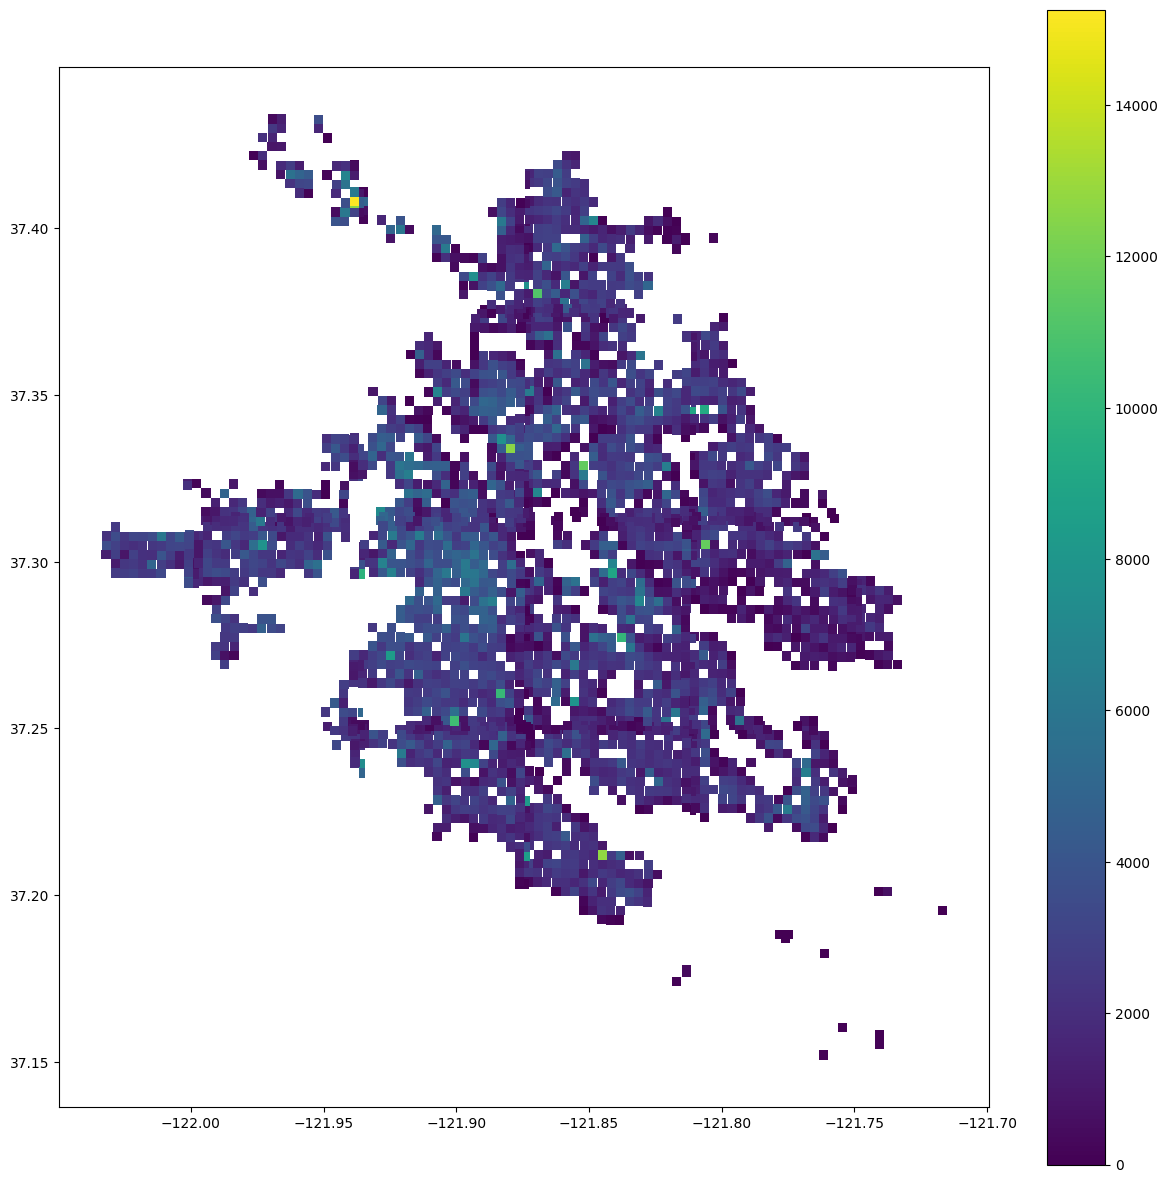

FP_detached_area


<Figure size 640x480 with 0 Axes>

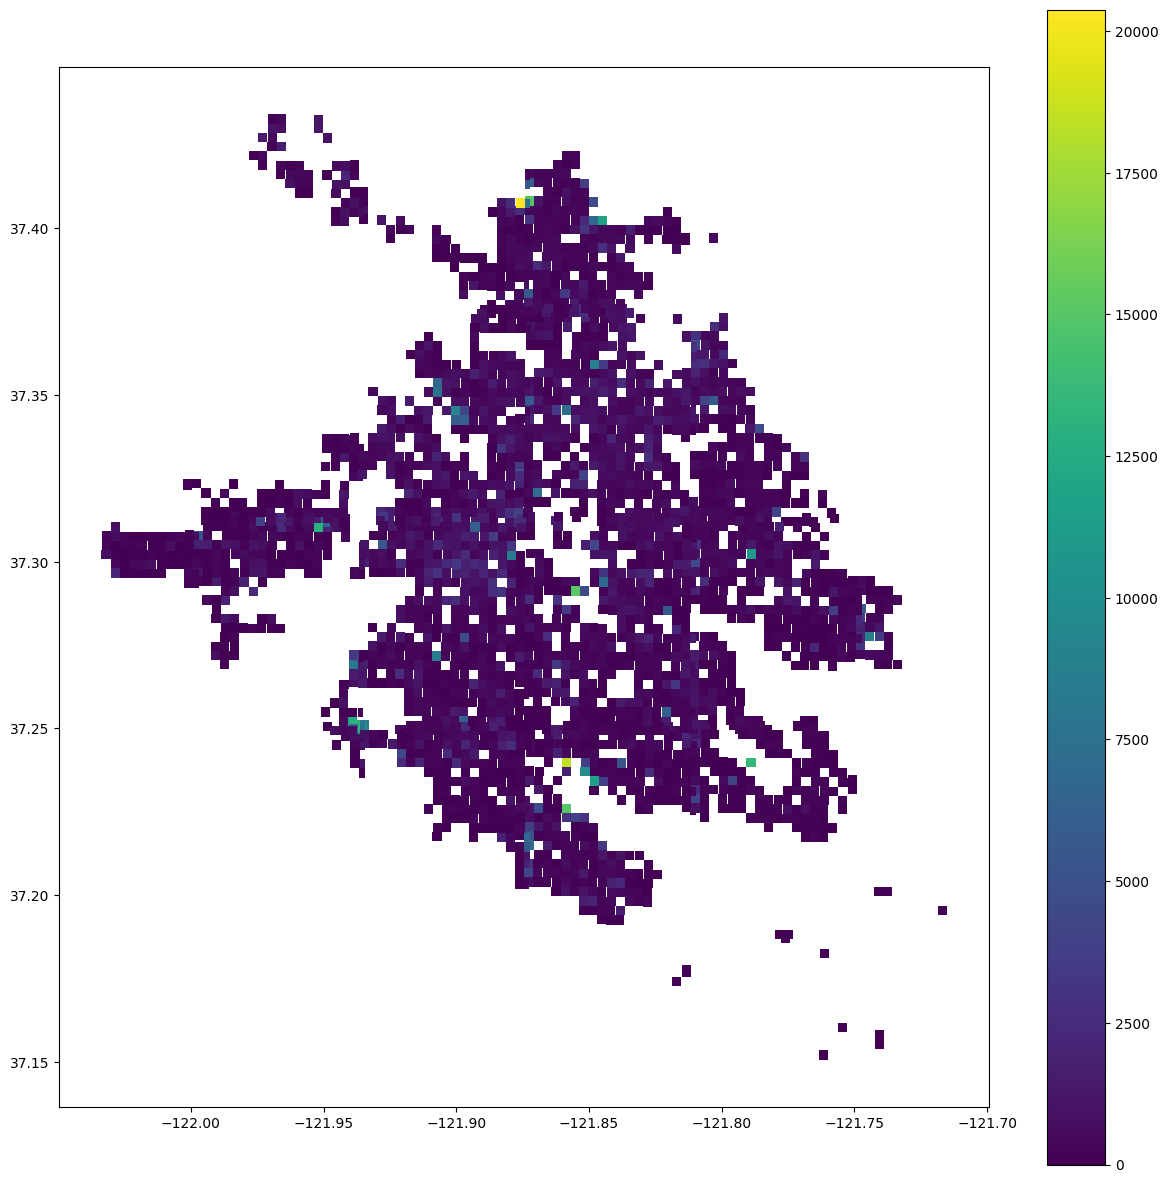

FP_attached_area


<Figure size 640x480 with 0 Axes>

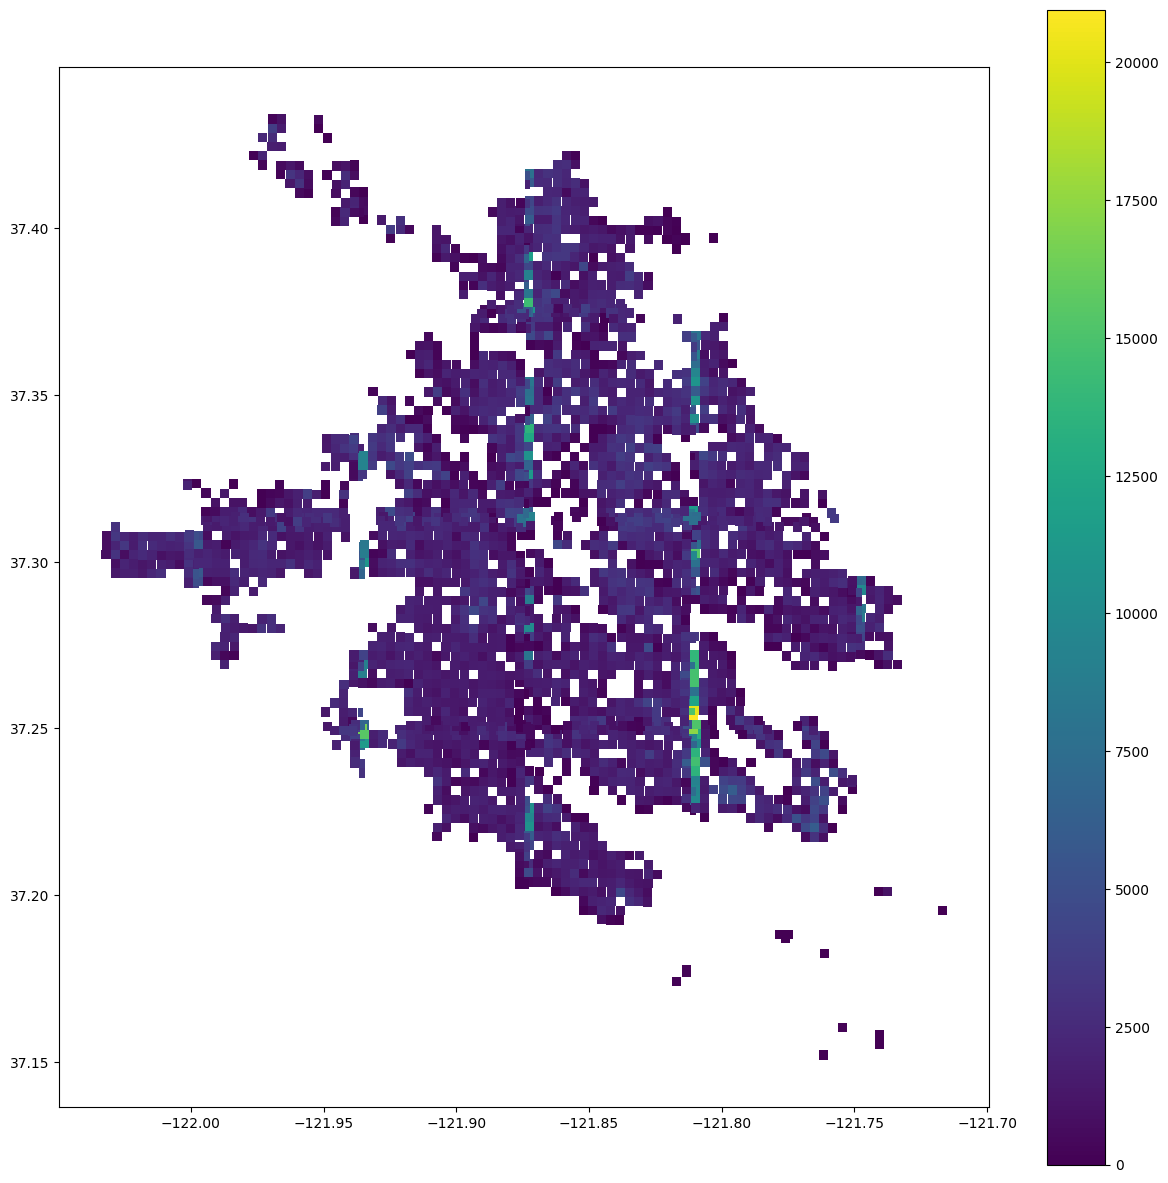

false_pos_perc


<Figure size 640x480 with 0 Axes>

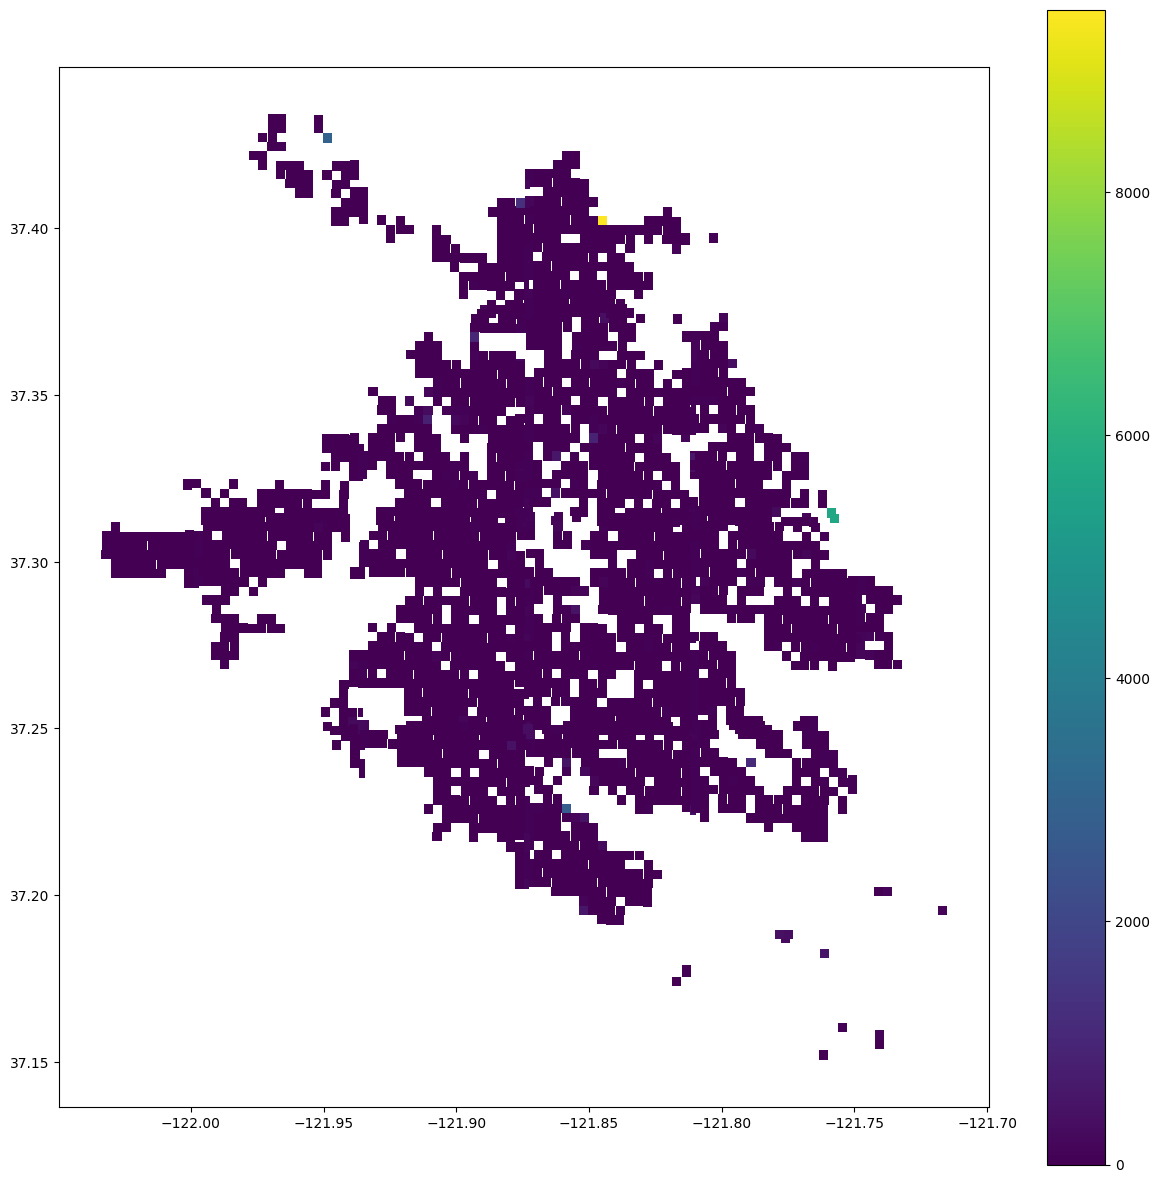

false_neg_perc


<Figure size 640x480 with 0 Axes>

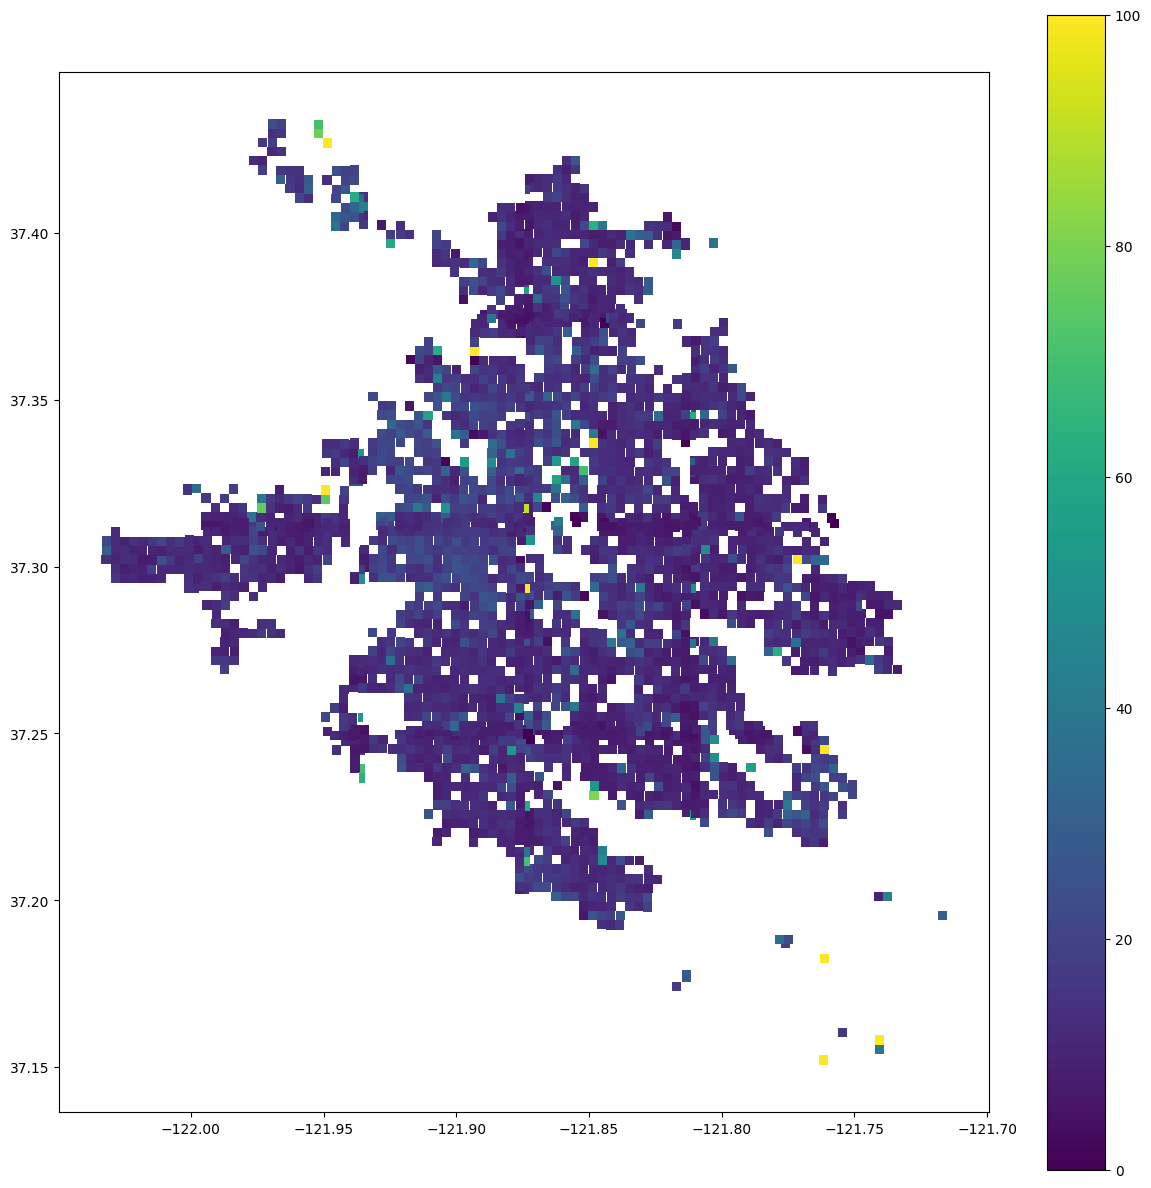

FP_detached_perc


<Figure size 640x480 with 0 Axes>

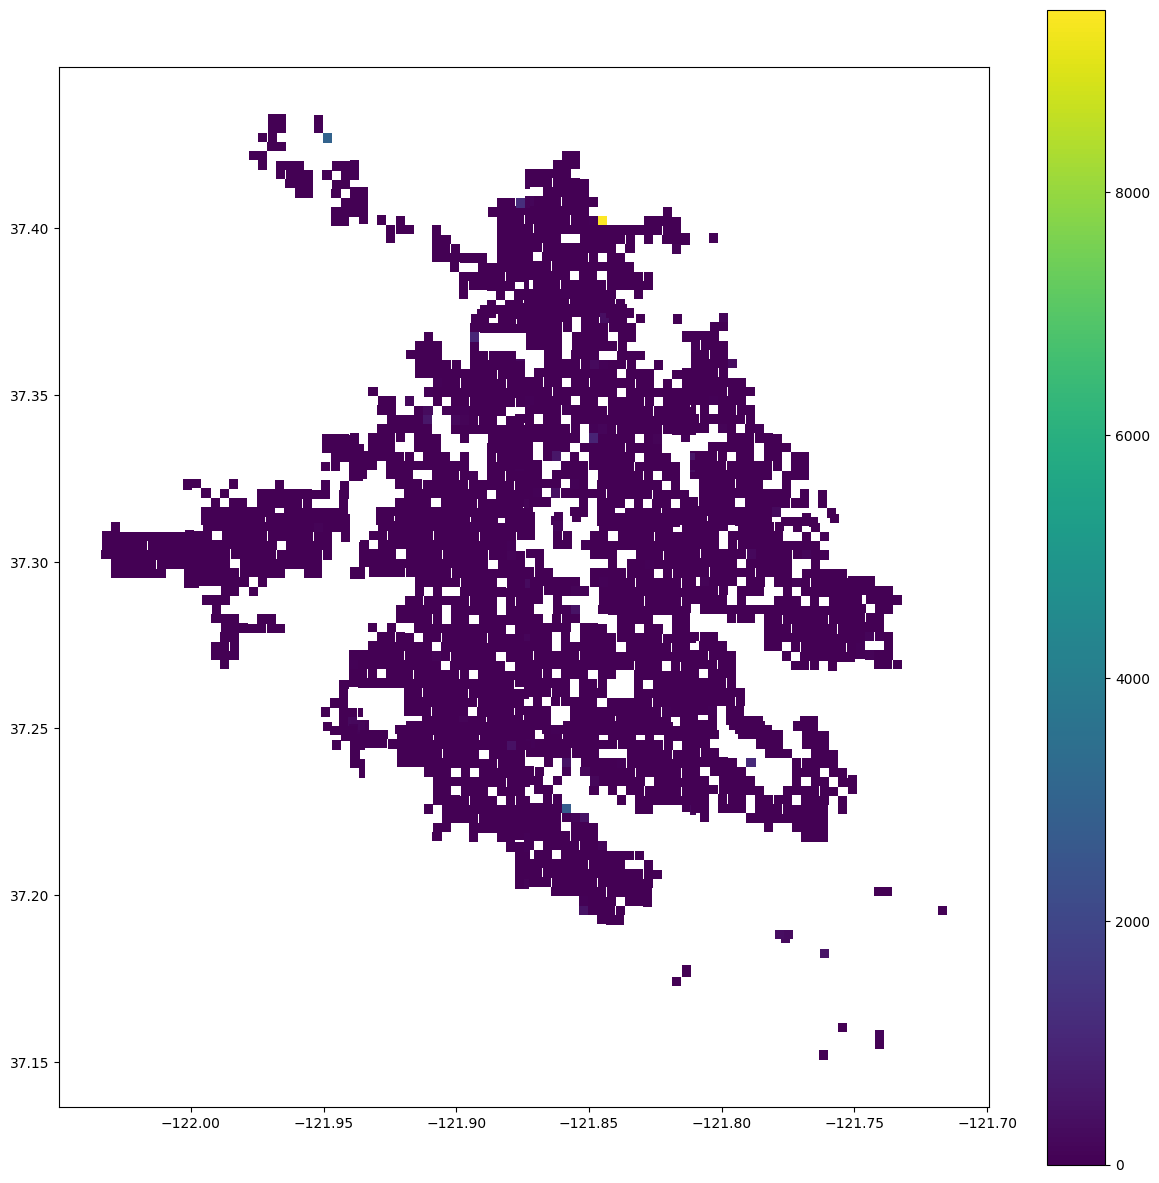

FP_attached_perc


<Figure size 640x480 with 0 Axes>

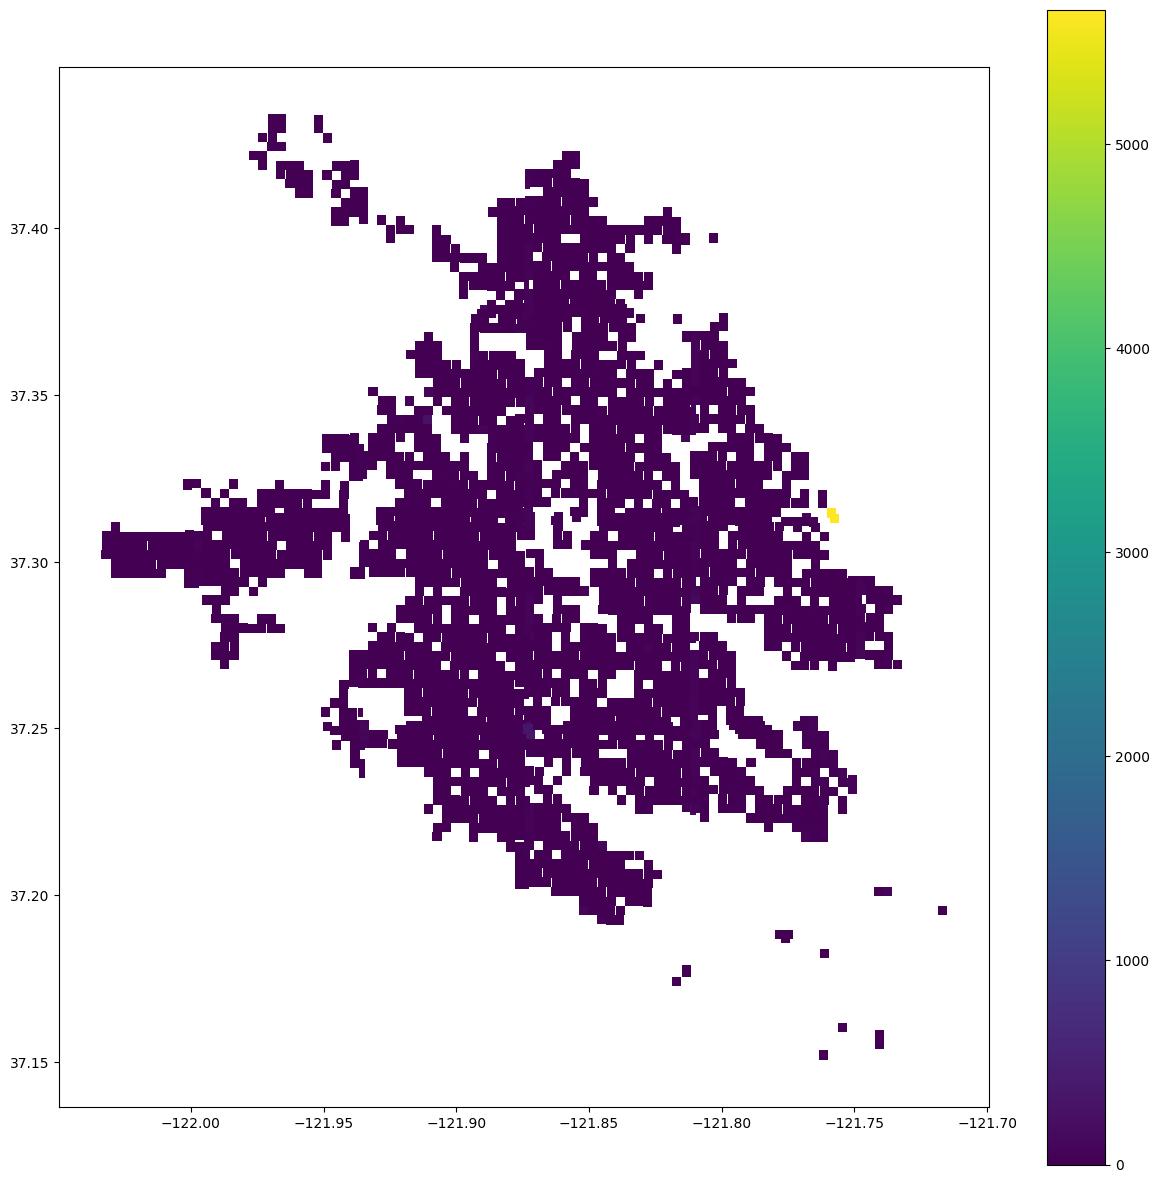

In [37]:
for col in ['false_pos_area', 'false_neg_area', 'FP_detached_area', 'FP_attached_area', 
            'false_pos_perc', 'false_neg_perc', 'FP_detached_perc', 'FP_attached_perc']:
    print(col)
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 15))
    tile_metrics_pd.plot(col, ax=ax, legend=True)
    plt.show()

<Figure size 640x480 with 0 Axes>

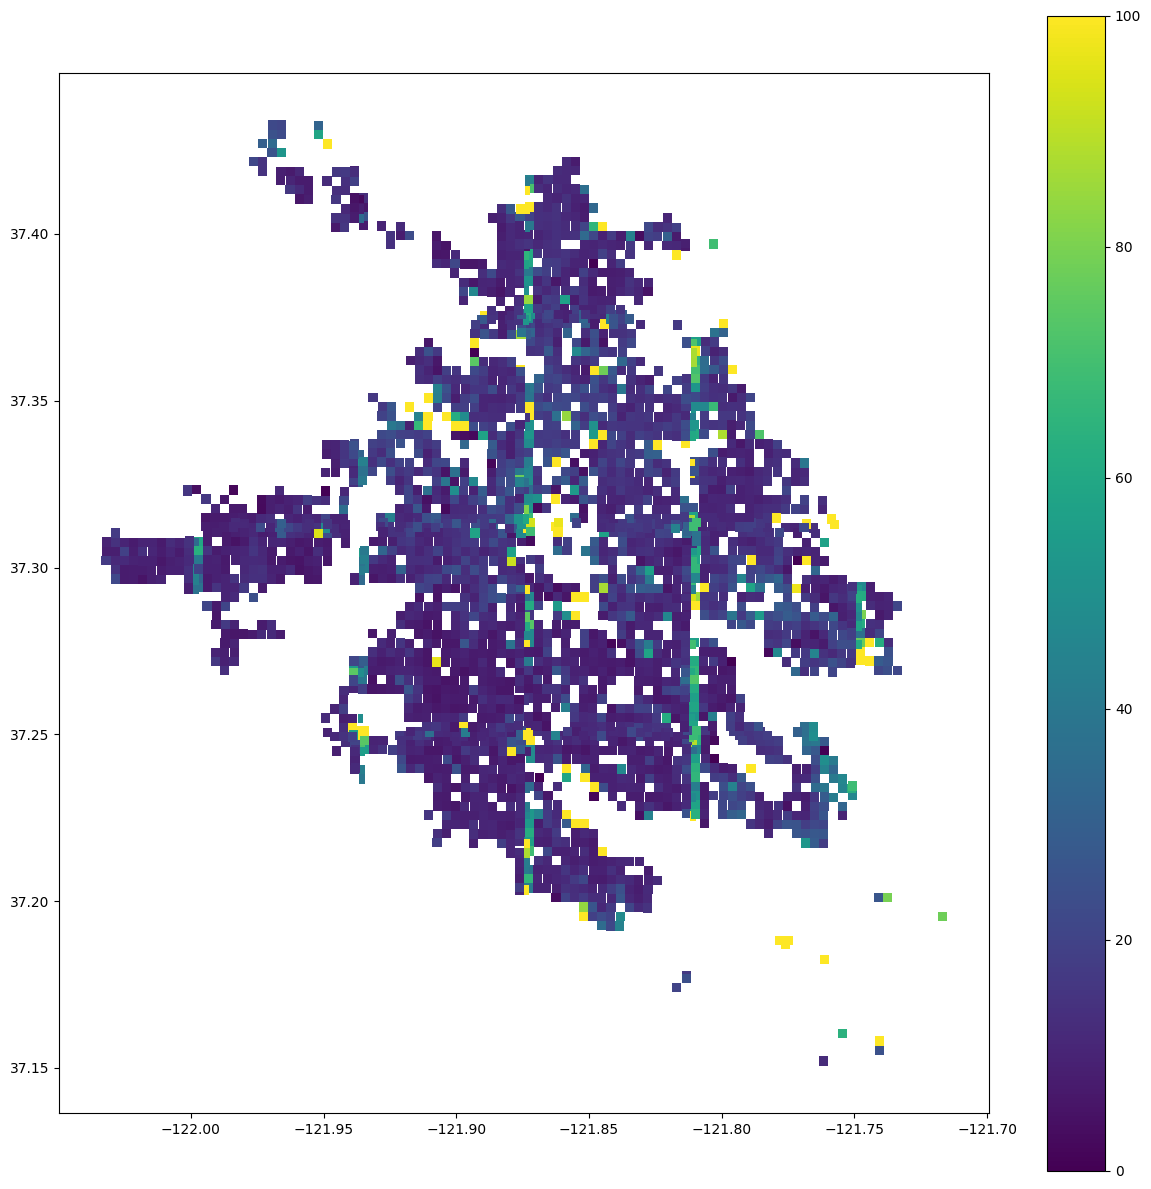

In [45]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
tile_metrics_pd.plot('false_pos_perc', ax=ax, legend=True, vmax=100)
plt.show()

In [43]:
tile_metrics_pd['false_pos_perc'].describe()

count    3072.000000
mean       33.401333
std       242.388739
min         0.000000
25%         9.716841
50%        13.289357
75%        20.622855
max      9500.692081
Name: false_pos_perc, dtype: float64

## Visualize sampled tiles

In [ ]:
file_name = 'm_3712149_ne_10_060_20200525_77'
tile_metrics = {file_name: tile_error}

# Visualize (sampled) tiles
def visualize_tile(tile_bounds_dict, tile_metrics, file_name, save=False):
    # Get image, OSM and inference
    img_file = None
    for dirname in ['train', 'val', 'test']:
        dirpath = os.path.join(IMG_FP, dirname, 'images', '{}.npy'.format(file_name))
        if os.path.exists(dirpath):
            img_file = dirpath
            
    tile_img = np.load(img_file)
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    zoning_tile = gpd.clip(zoning, tile_bounds)
    
    # Get error masks
    false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)
    
    # Print metrics # TODO save these to the image --print coords?
    metrics = tile_metrics[file_name]
    for metric, metric_val in metrics.items():
        print('{}: {}'.format(metric, round(metric_val, 2)))
    
    # Plot
    fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    ax1.imshow(tile_img)
    osm_tile.plot(ax=ax2)
    infer_tile.plot(ax=ax2, alpha=0.4, color='red')
    zoning_tile.plot(ax=ax3, zorder=1)
    zoning_tile.plot(ax=ax4, zorder=1)
    FP_detached.plot(ax=ax3, zorder=2, color='red')
    FP_attached.plot(ax=ax4, zorder=2, color='red') 
    plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_FP, 'Error-Analysis', '{}.png'.format(file_name)), bbox_inches='tight')
    else:
        plt.show()

In [ ]:
visualize_tile(tile_bounds_dict=tile_bounds_dict, tile_metrics=tile_metrics, 
               file_name=file_name, save=False)

Choose OSM building area threshold

In [ ]:
tile_metrics_cbg.sort_values('osm_area', ascending=True).iloc[300:302]

/usr/local/lib/python3.8/dist-packages/rasterio/plot.py:107: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


<Figure size 640x480 with 0 Axes>

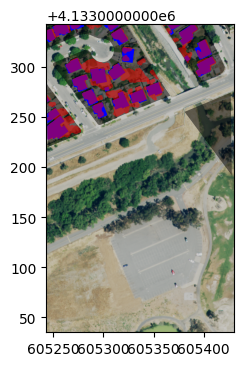

In [178]:
visualize_tile_full('m_3712142_nw_10_060_20200525_279')

# Playground

In [ ]:
# CHECK
tile_build_area = tile_metrics_cbg[['file', 'geometry']].sjoin(
    building_footprints_osm[['area', 'geometry']], predicate='intersects', how='right')

# GROUND TRUTH
visualize_tile_full('m_3712142_se_10_060_20200525_62')
fn = 'm_3712142_se_10_060_20200525_62'
tile_bounds = get_bounds(tile_bounds_dict, fn)
osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
osm_tile['area'].sum()

tile_build_area.loc[tile_build_area['file'] == 'm_3712142_se_10_060_20200525_62']['area'].sum()
tile_build_area = tile_build_area.groupby('file')['area'].sum().reset_index()
tile_build_area.loc[tile_build_area['file'] == 'm_3712142_se_10_060_20200525_62']['area']

tile_metrics_cbg.loc[tile_metrics_cbg['file'] == 'm_3712142_se_10_060_20200525_62']['area']

### Self-intersecting polygons

In [10]:
file_name = tiles[i]
tile_bounds = get_bounds(tile_bounds_dict, file_name)
infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
osm_tile = gpd.clip(building_footprints_osm, tile_bounds)

false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)

In [13]:
osm_tile

Empty GeoDataFrame
Columns: [index_left, GEOID, index, area, small, large, geometry]
Index: []

In [12]:
false_pos, false_neg, FP_detached, FP_attached

(Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 Empty GeoDataFrame
 Columns: [geometry]
 Index: [])

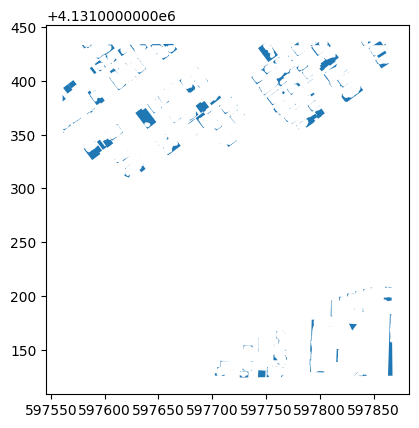

In [62]:
false_neg.to_crs('EPSG:26910').plot()
plt.show()

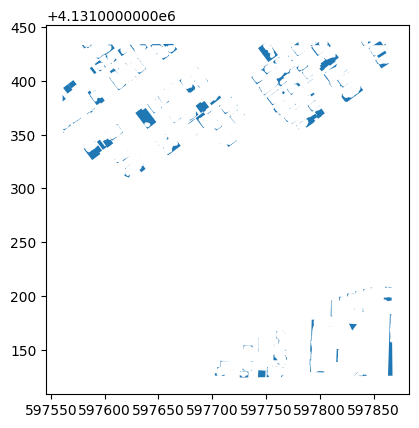

In [61]:
false_neg.to_crs('EPSG:26910').buffer(0.0000001).plot()
plt.show()

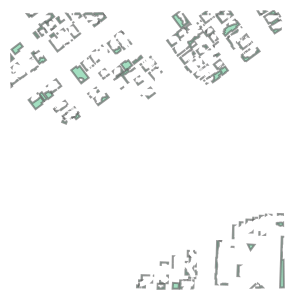

In [58]:
false_neg.to_crs('EPSG:26910').buffer(0.0000001).geometry.unary_union

In [53]:
x = false_neg[false_neg.to_crs('EPSG:26910').buffer(0.0001).geometry.is_valid == False].to_crs('EPSG:26910')

In [54]:
x

geometry
4   MULTIPOLYGON (((597807.562 4131436.084, 597810...
5   MULTIPOLYGON (((597796.873 4131435.959, 597796...
20  MULTIPOLYGON (((597637.748 4131429.300, 597637...
38  MULTIPOLYGON (((597657.408 4131344.886, 597657...

In [55]:
y = x.copy()
y.geometry.is_valid

4     False
5     False
20    False
38    False
dtype: bool

In [56]:
x.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

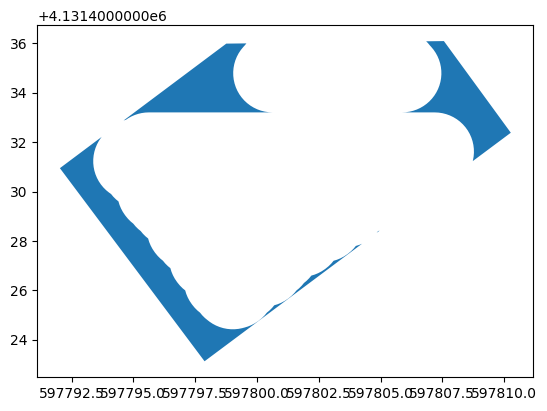

In [57]:
x.iloc[[0]].buffer(0.0000001).plot()
plt.show()

### Tile-level errors

In [11]:
file_name = 'm_3712149_ne_10_060_20200525_77'
tile_bounds = get_bounds(tile_bounds_dict, file_name)
infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
osm_tile = gpd.clip(building_footprints_osm, tile_bounds)

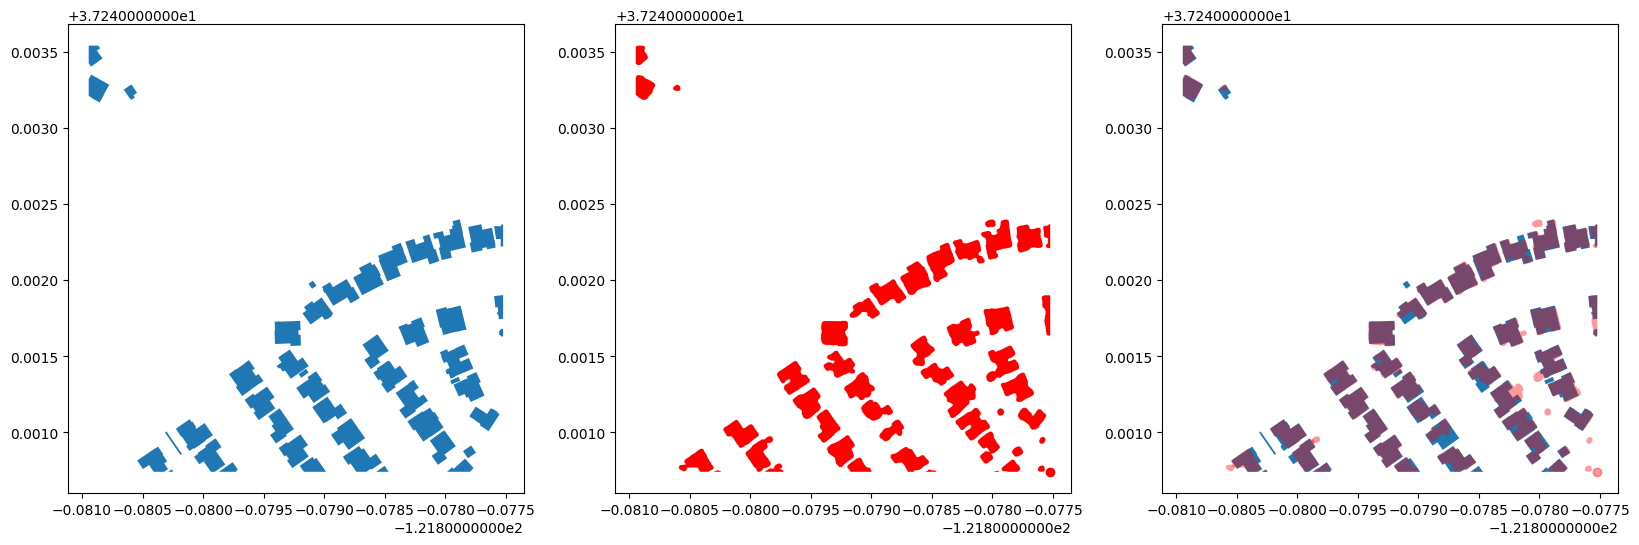

In [12]:
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
ax1 = osm_tile.plot(ax=ax1)
ax2 = infer_tile.plot(ax=ax2, color='red')
osm_tile.plot(ax=ax3)
infer_tile.plot(ax=ax3, alpha=0.4, color='red')
plt.show()

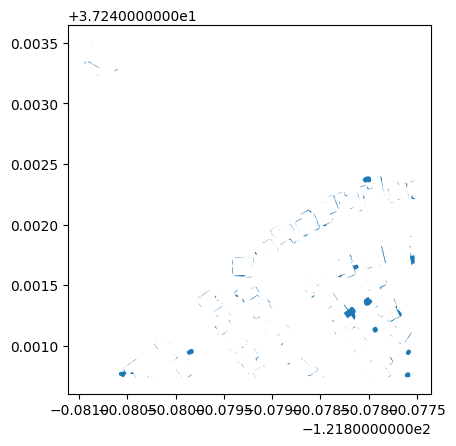

In [16]:
false_pos.plot()
plt.show()

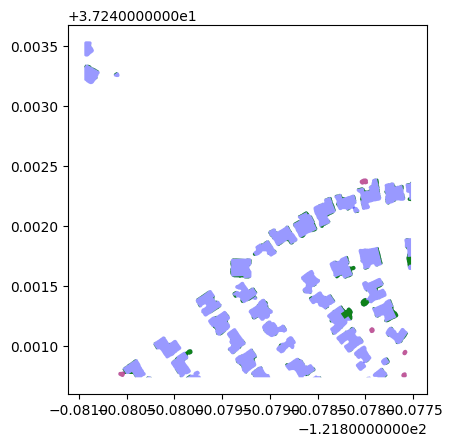

In [29]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
infer_tile.plot(ax=ax1, color='blue', alpha=0.4)
FP_detached.plot(ax=ax1, alpha=0.4, color='red')
FP_attached.plot(ax=ax1, alpha=0.9, color='green')
plt.show()

false_pos_area: 639.19
false_neg_area: 1157.86
FP_detached_area: 114.46
FP_attached_area: 524.73
false_pos_perc: 0.07
false_neg_perc: 0.12
FP_detached_perc: 0.01
FP_attached_perc: 0.05


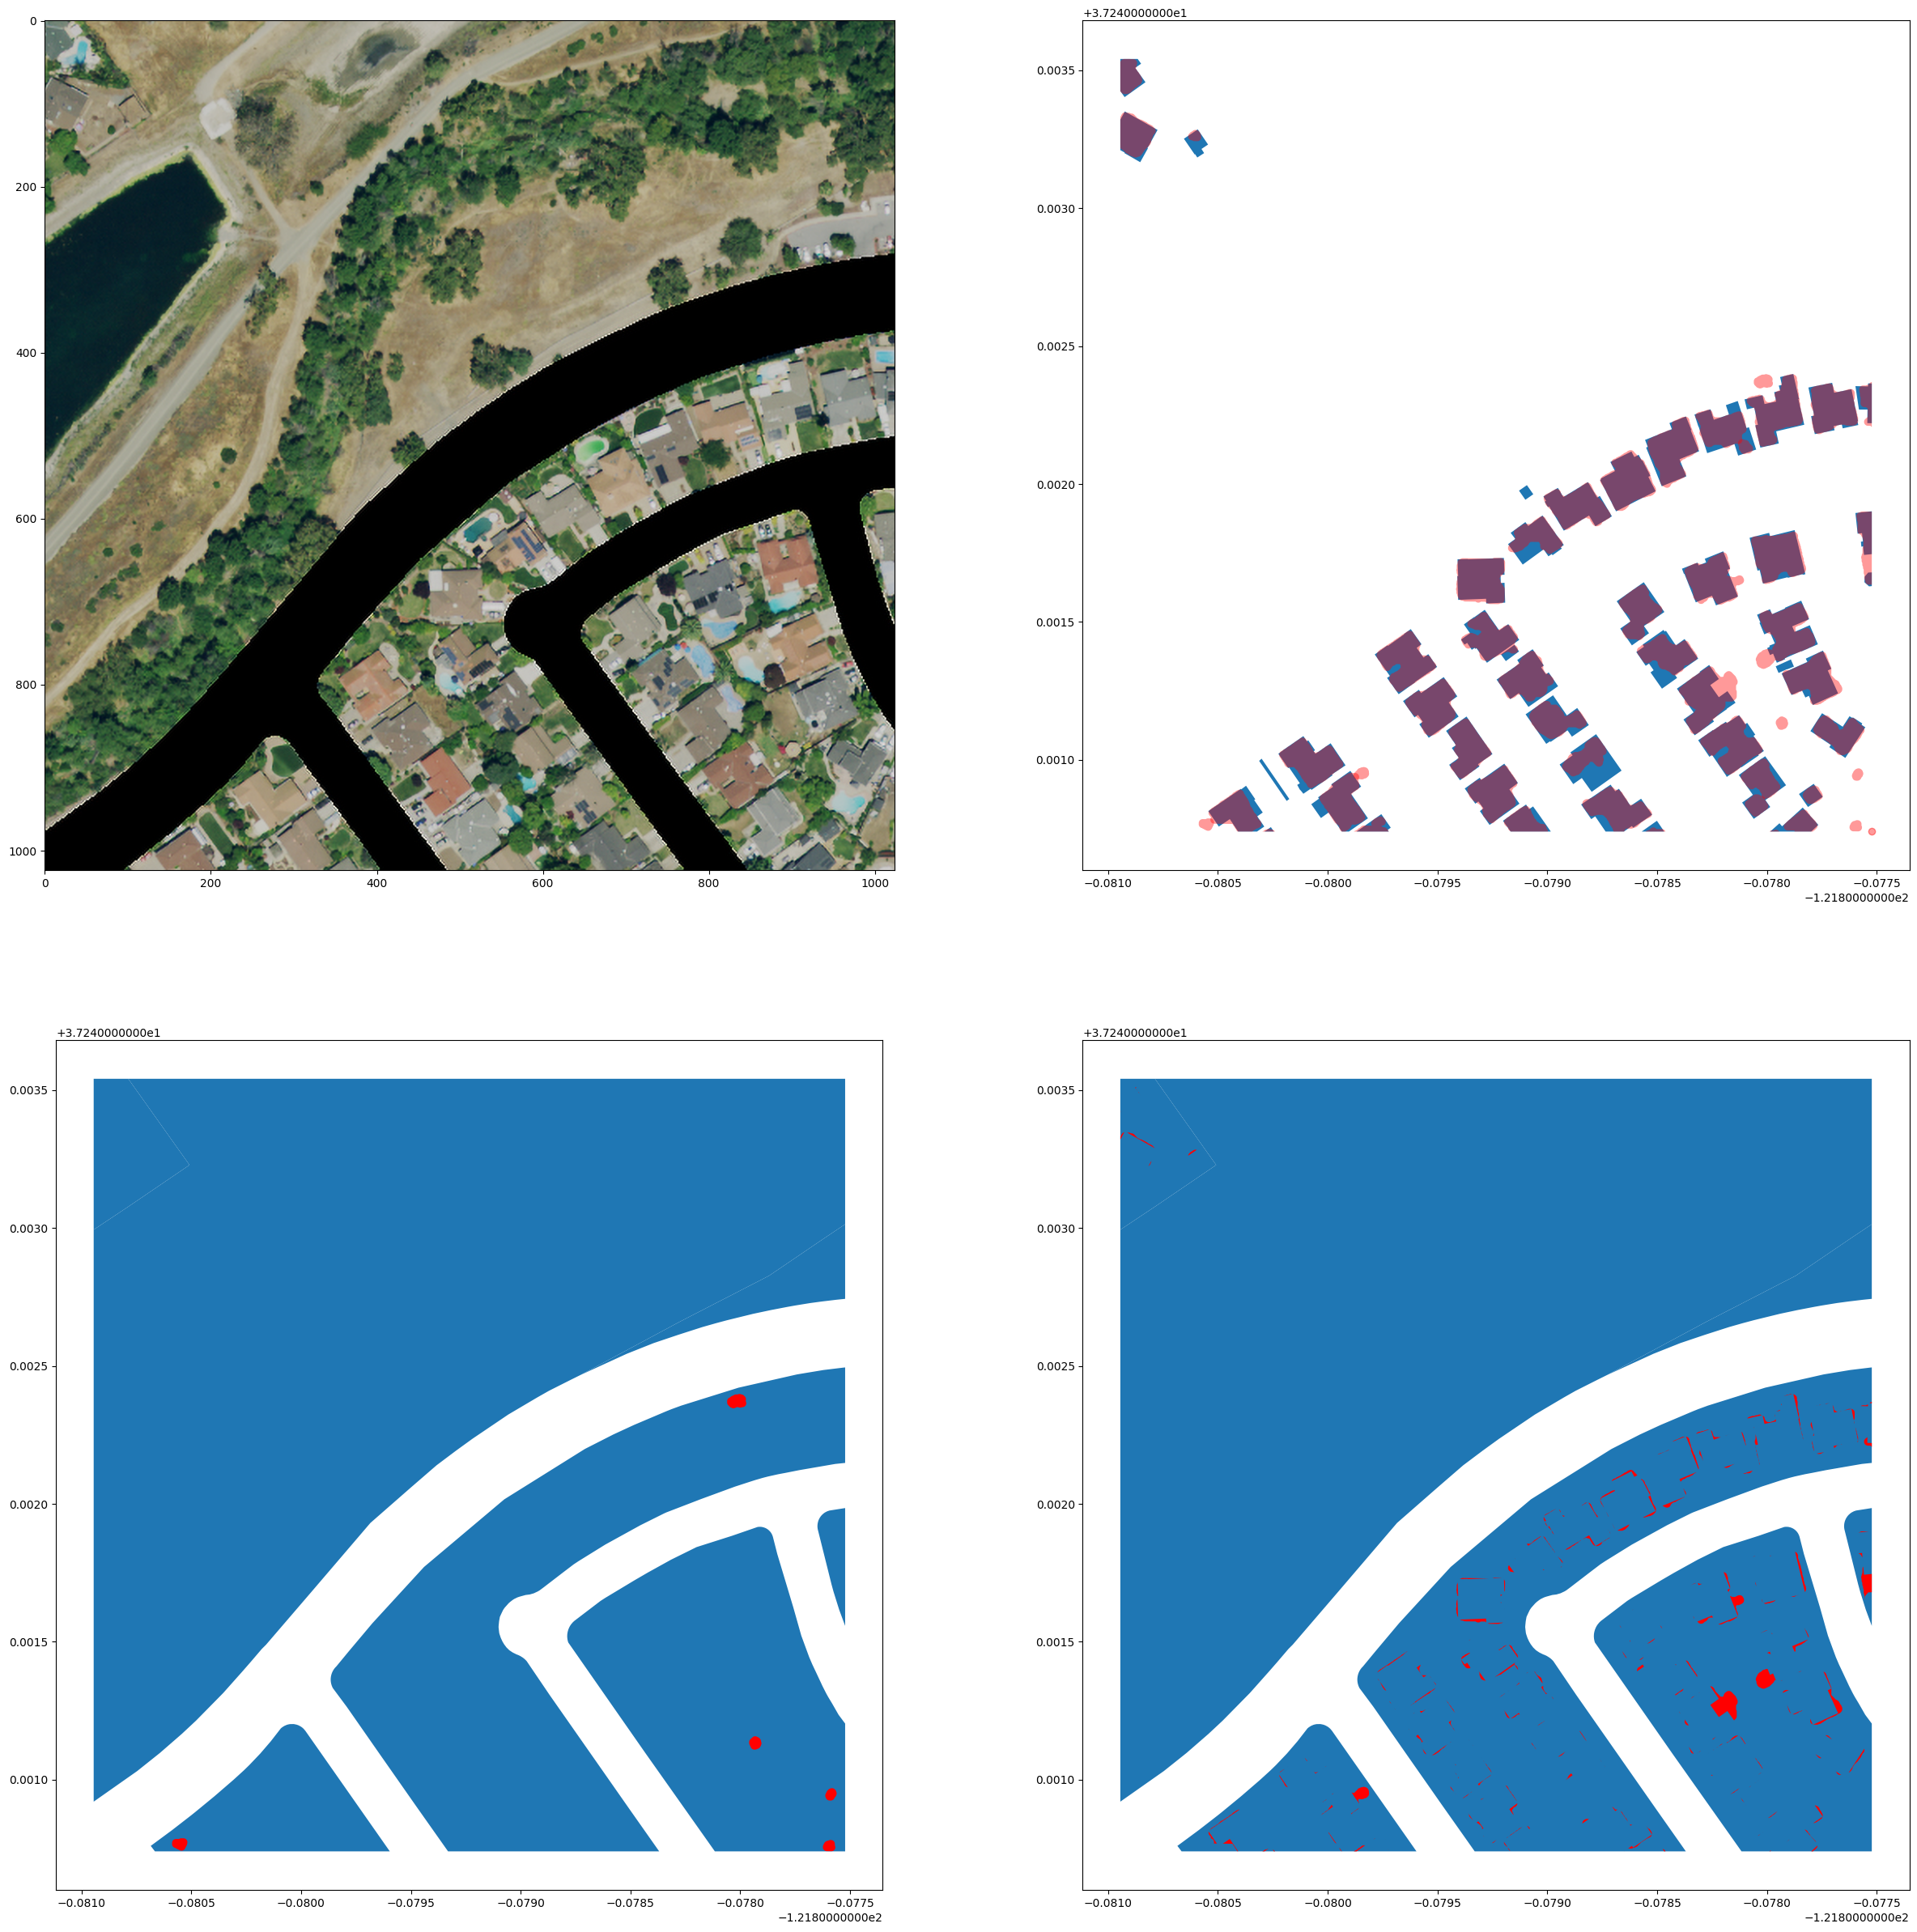